# Second Project

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from code import data_preparation as dp
from code import visualizations as viz
import matplotlib.pyplot as plt
%matplotlib inline

## Initial Data Preparation and Exploration

In [2]:
data = pd.read_csv('data/kc_house_data.csv')

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

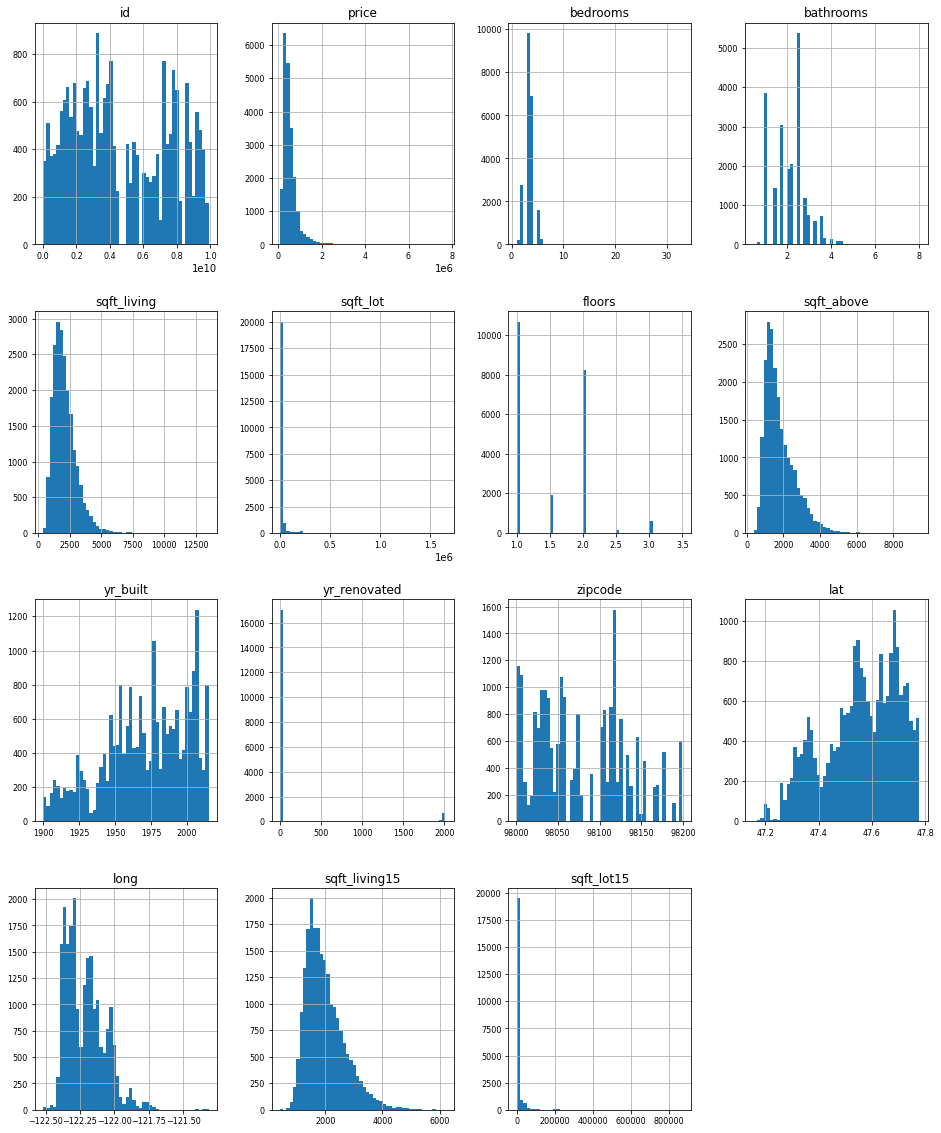

In [5]:
data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

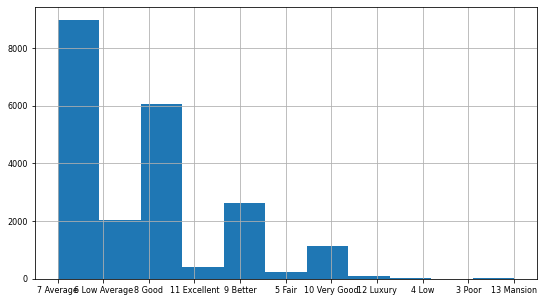

In [6]:
data['grade'].hist(figsize=(9, 5), bins=11, xlabelsize=8, ylabelsize=8);

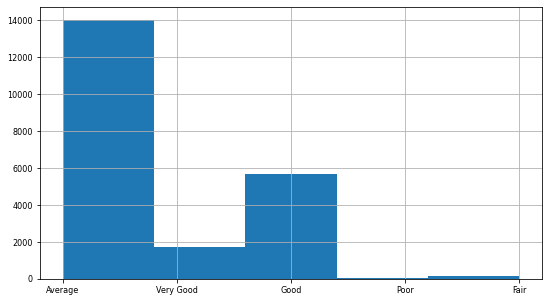

In [7]:
data['condition'].hist(figsize=(9, 5), bins=5, xlabelsize=8, ylabelsize=8);

In [8]:
data.id.value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [9]:
sum(data.id.value_counts()>1)

176

In [10]:
flipped = data[data.duplicated('id', keep=False) == True]
flipped.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,430000.0,3,1.50,1580,5000,1.0,NO,NONE,...,8 Good,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500
94,6021501535,12/23/2014,700000.0,3,1.50,1580,5000,1.0,NO,NONE,...,8 Good,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500
313,4139480200,6/18/2014,1380000.0,4,3.25,4290,12103,1.0,NO,GOOD,...,11 Excellent,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
314,4139480200,12/9/2014,1400000.0,4,3.25,4290,12103,1.0,NO,GOOD,...,11 Excellent,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
324,7520000520,9/5/2014,232000.0,2,1.00,1240,12092,1.0,NaN,NONE,...,6 Low Average,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
325,7520000520,3/11/2015,240500.0,2,1.00,1240,12092,1.0,NO,NONE,...,6 Low Average,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
345,3969300030,7/23/2014,165000.0,4,1.00,1000,7134,1.0,NO,NONE,...,6 Low Average,1000,0.0,1943,0.0,98178,47.4897,-122.240,1020,7138
346,3969300030,12/29/2014,239900.0,4,1.00,1000,7134,1.0,NO,NONE,...,6 Low Average,1000,0.0,1943,NaN,98178,47.4897,-122.240,1020,7138
371,2231500030,10/1/2014,315000.0,4,2.25,2180,10754,1.0,NaN,NONE,...,7 Average,1100,1080.0,1954,0.0,98133,47.7711,-122.341,1810,6929
372,2231500030,3/24/2015,530000.0,4,2.25,2180,10754,1.0,NO,NONE,...,7 Average,1100,1080.0,1954,0.0,98133,47.7711,-122.341,1810,6929


In [11]:
flipped[flipped['yr_renovated']>1970]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
324,7520000520,9/5/2014,232000.0,2,1.00,1240,12092,1.0,NaN,NONE,...,6 Low Average,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
325,7520000520,3/11/2015,240500.0,2,1.00,1240,12092,1.0,NO,NONE,...,6 Low Average,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
717,8820903380,7/28/2014,452000.0,6,2.25,2660,13579,2.0,NO,NONE,...,7 Average,2660,0.0,1937,1990.0,98125,47.7142,-122.286,1120,8242
718,8820903380,1/2/2015,730000.0,6,2.25,2660,13579,2.0,NO,NONE,...,7 Average,2660,0.0,1937,1990.0,98125,47.7142,-122.286,1120,8242
3946,1825069031,8/14/2014,550000.0,4,1.75,2410,8447,2.0,NO,GOOD,...,8 Good,2060,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789
3947,1825069031,10/16/2014,550000.0,4,1.75,2410,8447,2.0,NaN,GOOD,...,8 Good,2060,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789


Since we are not doing time analysis we will delete the date column. The id number cannot be used in regression and will be removed. We will use zipcodes for location information and so will remove lat/long info as well.

In [12]:
irrelevant = ['id', 'date', 'lat', 'long']
relevant = data.drop(columns=irrelevant)

In [13]:
relevant.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,1800,7503


### Dealing with Missing Values

#### *Missing Renovation Year Data*

We can see there are 3842 missing values about what year renovations we done, and a large number of zero values as well.

In [14]:
relevant['yr_renovated'].isna().sum()

3842

In [15]:
relevant['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

We will add a column indicating which values are missing and assume that NaN values are 0 values and represent no renovation. We will also bin the renovations into three categories: "not_renovated", "new_renovations", "old_renovations". We will define new renovations as ones that have been done in the past 10 years. We will then one-hot encode it so it can be used in a regression.

In [16]:
relevant['yr_ren_miss'] = dp.missing_indicator(relevant, 'yr_renovated')

In [17]:
relevant['yr_renovated'] = dp.impute_values(relevant, 'yr_renovated', type='median')

In [18]:
relevant['yr_renovated'].isna().sum()

0

In [19]:
def find_old_new(x, threshold=10):
    if x > (2020-threshold):
        return "new_ren"
    elif x == 0:
        return "not_ren"
    else:
        return "old_ren"

In [20]:
relevant['yr_renovated'] = relevant['yr_renovated'].apply(find_old_new)

In [21]:
cats_yr_ren, encode_yr_ren = dp.one_hot_encode(relevant, 'yr_renovated')

In [22]:
relevant[cats_yr_ren] = encode_yr_ren 

In [23]:
#One column dropped to avoid dummy variable trap
clean = relevant.drop(columns=['yr_renovated', 'not_ren'])

In [24]:
clean.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,yr_ren_miss,new_ren,old_ren
0,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,98178,1340,5650,False,0.0,0.0
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,98125,1690,7639,False,0.0,1.0
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,98028,2720,8062,True,0.0,0.0
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,98136,1360,5000,False,0.0,0.0
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,98074,1800,7503,False,0.0,0.0


We still have to deal with the missing waterfront and view data.

In [25]:
clean['waterfront'].isna().sum()

2376

In [26]:
clean['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

For the waterfront data, we will also add a missing column and will assume that the missing values are properties that lack a waterfront. We will also binary encode this column.

In [27]:
clean['waterfront_miss'] = dp.missing_indicator(clean, 'waterfront')

In [28]:
clean = clean.replace({'NO': 0, 'YES': 1})

In [29]:
clean['waterfront'] = dp.impute_values(clean, 'waterfront', type='median')

In [30]:
clean.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,yr_ren_miss,new_ren,old_ren,waterfront_miss
0,221900.0,3,1.00,1180,5650,1.0,0.0,NONE,Average,7 Average,1180,0.0,1955,98178,1340,5650,False,0.0,0.0,True
1,538000.0,3,2.25,2570,7242,2.0,0.0,NONE,Average,7 Average,2170,400.0,1951,98125,1690,7639,False,0.0,1.0,False
2,180000.0,2,1.00,770,10000,1.0,0.0,NONE,Average,6 Low Average,770,0.0,1933,98028,2720,8062,True,0.0,0.0,False
3,604000.0,4,3.00,1960,5000,1.0,0.0,NONE,Very Good,7 Average,1050,910.0,1965,98136,1360,5000,False,0.0,0.0,False
4,510000.0,3,2.00,1680,8080,1.0,0.0,NONE,Average,8 Good,1680,0.0,1987,98074,1800,7503,False,0.0,0.0,False


In [31]:
clean['waterfront'].isna().sum()

0

We will now deal with the view data.

In [32]:
clean['view'].isna().sum()

63

In [33]:
clean['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Given how few homes are actually rated, we will drop the view column from out analysis.

In [34]:
clean = clean.drop(columns=['view'])
clean.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,yr_ren_miss,new_ren,old_ren,waterfront_miss
0,221900.0,3,1.00,1180,5650,1.0,0.0,Average,7 Average,1180,0.0,1955,98178,1340,5650,False,0.0,0.0,True
1,538000.0,3,2.25,2570,7242,2.0,0.0,Average,7 Average,2170,400.0,1951,98125,1690,7639,False,0.0,1.0,False
2,180000.0,2,1.00,770,10000,1.0,0.0,Average,6 Low Average,770,0.0,1933,98028,2720,8062,True,0.0,0.0,False
3,604000.0,4,3.00,1960,5000,1.0,0.0,Very Good,7 Average,1050,910.0,1965,98136,1360,5000,False,0.0,0.0,False
4,510000.0,3,2.00,1680,8080,1.0,0.0,Average,8 Good,1680,0.0,1987,98074,1800,7503,False,0.0,0.0,False


We have now dealt with the missing data.

In [35]:
clean.isna().sum()

price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
condition          0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
zipcode            0
sqft_living15      0
sqft_lot15         0
yr_ren_miss        0
new_ren            0
old_ren            0
waterfront_miss    0
dtype: int64

### Dealing with Non-Numerical Data

In order to make a model we need to transform categorical data into numerical data. As we can see the condition, grade, and sqft_basement columns are objects, and will have to be transformed.

In [36]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21597 non-null  float64
 1   bedrooms         21597 non-null  int64  
 2   bathrooms        21597 non-null  float64
 3   sqft_living      21597 non-null  int64  
 4   sqft_lot         21597 non-null  int64  
 5   floors           21597 non-null  float64
 6   waterfront       21597 non-null  float64
 7   condition        21597 non-null  object 
 8   grade            21597 non-null  object 
 9   sqft_above       21597 non-null  int64  
 10  sqft_basement    21597 non-null  object 
 11  yr_built         21597 non-null  int64  
 12  zipcode          21597 non-null  int64  
 13  sqft_living15    21597 non-null  int64  
 14  sqft_lot15       21597 non-null  int64  
 15  yr_ren_miss      21597 non-null  bool   
 16  new_ren          21597 non-null  float64
 17  old_ren     

#### *Dealing with Grade Column*

As we can see the grade column does include numerical ratings along with a short description of what they mean. 

In [37]:
clean['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

However since we can' assume that a 10 is twice as good as a 5, we will one-hot encoded the grades, as well as drop homes in the the mansion and poor categories since they are outlier unlikely to be relevant to the median homeseller.

In [38]:
clean['grade'] = clean['grade'].map(lambda x: x.split()[0])

In [39]:
clean = clean.drop(clean[clean.grade == '13'].index)

In [40]:
clean = clean.drop(clean[clean.grade == '3'].index)

In [41]:
clean['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
Name: grade, dtype: int64

In [42]:
cats_grade, encode_grade = dp.one_hot_encode(clean, 'grade', prefix='grade_')
clean[cats_grade] = encode_grade 

In [43]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['grade', 'grade_12'])

In [44]:
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'sqft_above', 'sqft_basement', 'yr_built',
       'zipcode', 'sqft_living15', 'sqft_lot15', 'yr_ren_miss', 'new_ren',
       'old_ren', 'waterfront_miss', 'grade_10', 'grade_11', 'grade_4',
       'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9'],
      dtype='object')

#### *Dealing with Condition Column*

The condition column must also be encoded.

In [45]:
clean['condition'].value_counts()

Average      14009
Good          5675
Very Good     1700
Fair           170
Poor            29
Name: condition, dtype: int64

Like the grade column we will one-hot encoding it.

In [46]:
cats_cond, encode_cond = dp.one_hot_encode(clean, 'condition', prefix='cond_')

In [47]:
clean[cats_cond]=encode_cond

In [48]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['condition', 'cond_Poor'])

In [49]:
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above', 'sqft_basement', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'yr_ren_miss', 'new_ren', 'old_ren',
       'waterfront_miss', 'grade_10', 'grade_11', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'cond_Average', 'cond_Fair',
       'cond_Good', 'cond_Very Good'],
      dtype='object')

#### *Dealing with Sqft Basement Column*

As we can see, there are many 0 values along with some hidden missing values that were input as '?'.

In [50]:
clean['sqft_basement'].value_counts()

0.0       12822
?           454
600.0       216
500.0       209
700.0       207
          ...  
1852.0        1
1275.0        1
915.0         1
475.0         1
2600.0        1
Name: sqft_basement, Length: 301, dtype: int64

We will make a column marking the missing values and replace them with the median value.

In [51]:
clean['sqft_basement'].replace('?', np.nan, inplace=True)
clean['sqft_base_miss'] = dp.missing_indicator(clean, 'sqft_basement')

In [52]:
clean['sqft_basement'] = dp.impute_values(clean,'sqft_basement', type='median')

In [53]:
clean['sqft_basement'].value_counts()

0.0       13276
600.0       216
500.0       209
700.0       207
800.0       201
          ...  
518.0         1
266.0         1
915.0         1
1930.0        1
65.0          1
Name: sqft_basement, Length: 300, dtype: int64

Lastly we will convert the boolean values of the missings columns to int for the purpose of regression.

In [54]:
clean[["yr_ren_miss","sqft_base_miss","waterfront_miss"]] = clean[["yr_ren_miss","sqft_base_miss","waterfront_miss"]].astype(int)

In [55]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21583 entries, 0 to 21596
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21583 non-null  float64
 1   bedrooms         21583 non-null  int64  
 2   bathrooms        21583 non-null  float64
 3   sqft_living      21583 non-null  int64  
 4   sqft_lot         21583 non-null  int64  
 5   floors           21583 non-null  float64
 6   waterfront       21583 non-null  float64
 7   sqft_above       21583 non-null  int64  
 8   sqft_basement    21583 non-null  float64
 9   yr_built         21583 non-null  int64  
 10  zipcode          21583 non-null  int64  
 11  sqft_living15    21583 non-null  int64  
 12  sqft_lot15       21583 non-null  int64  
 13  yr_ren_miss      21583 non-null  int32  
 14  new_ren          21583 non-null  float64
 15  old_ren          21583 non-null  float64
 16  waterfront_miss  21583 non-null  int32  
 17  grade_10    

All the obviously categorical data is in numerical form now but some categorical data is still there.

 ### Dealing with Locations

To deal with locations, we will bin the data by neighborhood, to do so we will use a csv file I created with each zipcode in King County labeled by neighborhood.

In [56]:
neighborhoods = pd.read_csv('data/king_county_neighborhoods.csv')
neighborhoods.head()

,Zipcode,Neighborhood
0,98010,Black Diamond
1,98038,Maple Valley
2,98070,Vashon Island
3,98023,Federal Way
4,98003,Federal Way


As we can see there are labels for all the zipcodes in the data set plus a few more in King County that had no home sales in the data.

In [58]:
set(clean.zipcode.unique()) - set(neighborhoods['Zipcode'])

set()

In [59]:
set(neighborhoods['Zipcode']) - set(clean.zipcode.unique())

{98047, 98051, 98057, 98101, 98104, 98121, 98134, 98158, 98195, 98224, 98288}

Using the info in the file we can convert the zipcodes into neighborhood labels and then one-hot encode them.

In [60]:
neighborhoods.set_index("Zipcode", inplace = True)
neighbor_dict = neighborhoods.to_dict()

In [61]:
clean['zipcode'] = clean['zipcode'].replace(neighbor_dict['Neighborhood'])

In [62]:
clean.zipcode.value_counts()

N Seattle         1600
Renton            1596
Ballard           1421
Bellevue          1404
West Seattle      1282
Kent              1201
Redmond           1175
Kirkland           976
SE Seattle         955
Auburn             911
NE Seattle         812
Burlen             811
Sammamish          800
Federal Way        779
Issaquah           733
Downtown           633
Queen Anne         609
Maple Valley       589
Capital Hill       371
Snoqualmie         308
Kenmore            283
Mercer Island      282
Des Moines         280
Woodinville        273
SE King County     232
North Bend         220
Bothell            195
Seatac             193
Duvail             190
Carnation          124
Vashon Island      117
Black Diamond      100
NE King County      80
Medina              48
Name: zipcode, dtype: int64

In [63]:
cats_zip, encode_zip = dp.one_hot_encode(clean, 'zipcode')
clean[cats_zip] = encode_zip

In [64]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['zipcode', 'Medina'])

In [65]:
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'yr_ren_miss', 'new_ren', 'old_ren',
       'waterfront_miss', 'grade_10', 'grade_11', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'cond_Average', 'cond_Fair',
       'cond_Good', 'cond_Very Good', 'sqft_base_miss', 'Auburn', 'Ballard',
       'Bellevue', 'Black Diamond', 'Bothell', 'Burlen', 'Capital Hill',
       'Carnation', 'Des Moines', 'Downtown', 'Duvail', 'Federal Way',
       'Issaquah', 'Kenmore', 'Kent', 'Kirkland', 'Maple Valley',
       'Mercer Island', 'N Seattle', 'NE King County', 'NE Seattle',
       'North Bend', 'Queen Anne', 'Redmond', 'Renton', 'SE King County',
       'SE Seattle', 'Sammamish', 'Seatac', 'Snoqualmie', 'Vashon Island',
       'West Seattle', 'Woodinville'],
      dtype='object')

The floor, bathroom, and bedroom data perhaps ought to be treated as categorical too, but for now we will proceed.

## Making a Base Model

To begin we will construct a basic model that just predicts how prices based on the most correlated variable with home prices.

In [66]:
locations = ['Auburn', 'Ballard', 'Bellevue', 'Black Diamond', 'Bothell', 'Burlen',
                 'Capital Hill', 'Carnation', 'Des Moines', 'Downtown', 'Duvail',
                 'Federal Way', 'Issaquah', 'Kenmore', 'Kent', 'Kirkland',
                 'Maple Valley', 'Mercer Island', 'N Seattle',
                 'NE King County', 'NE Seattle', 'North Bend', 'Queen Anne', 'Redmond',
                 'Renton', 'SE King County', 'SE Seattle', 'Sammamish', 'Seatac',
                 'Snoqualmie', 'Vashon Island', 'West Seattle', 'Woodinville']
non_location = clean.drop(columns = locations)

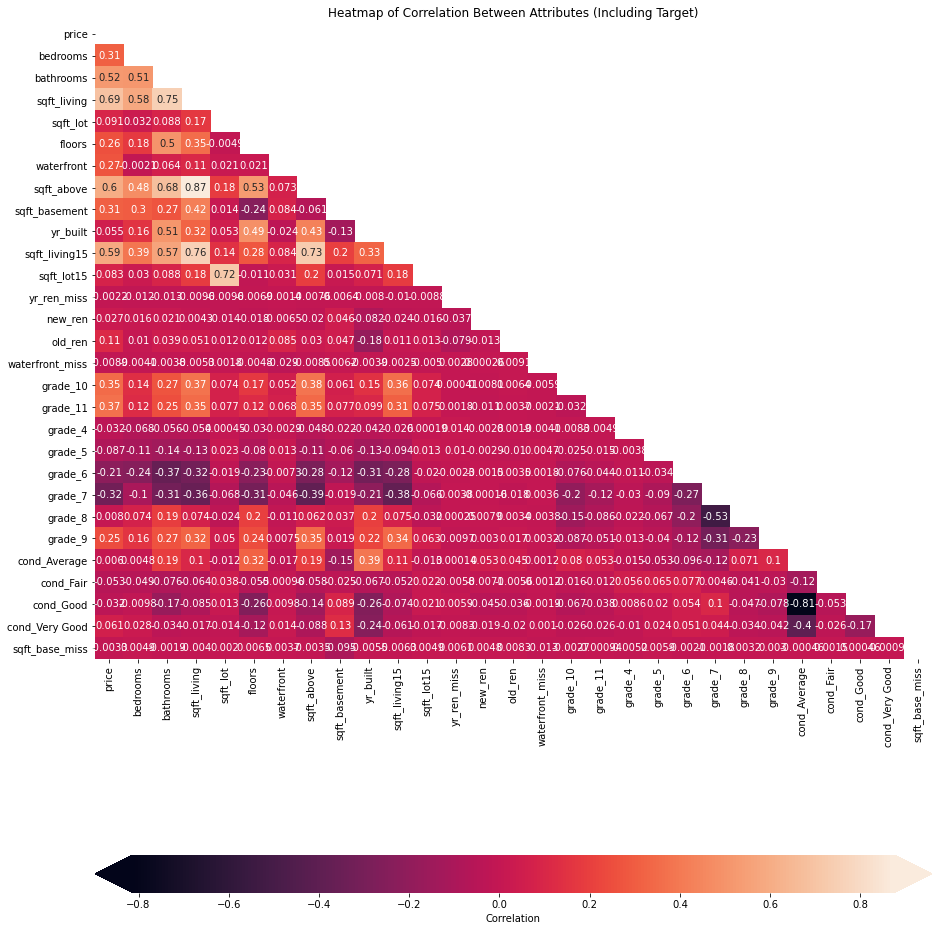

In [67]:
viz.create_heatmap(non_location, size =(15,18))

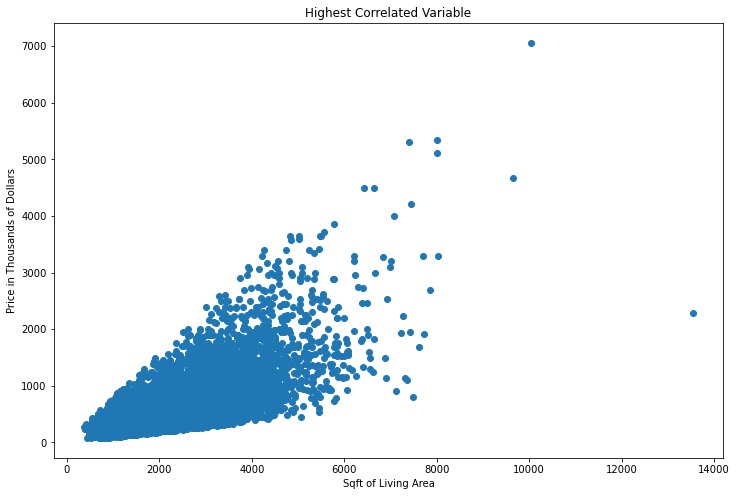

In [68]:
X_train = clean[['sqft_living']]
y_train = clean['price']
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X_train, y_train/1000)
plt.xlabel('Sqft of Living Area')
plt.ylabel('Price in Thousands of Dollars')
plt.title('Highest Correlated Variable');

In our initial model we will only use 'sqft_living' the variable most correlated with our target variable price. 

In [69]:
baseline_model = LinearRegression()
base_val = dp.cross_val(baseline_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.48295393411547033
Validation score: 0.4809902533078457


The squre footage of the living space only accounts for about 48% of the variance in our data, given the visualization of their relationship, we can see that the variance in price also increases with the living space, indicating the data is likely heteroskedastic, so a linear model on just this variable will be inefficient.

## Improving the Model

The first thing we can attempt to do to improve the model is add in more variables. Let's add them all in and see how the model performs.

In [70]:
X_train = clean.drop(columns='price')
y_train = clean['price']
all_model = LinearRegression()
all_val = dp.cross_val(all_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.790210134142975
Validation score: 0.7881209244583942


As we can see, all the varibles explain about 79% of the variance in price in our data as it stands. One potential place that we could still be having issues is in the normality of the data. Let's look at a Q-Q plot to check.

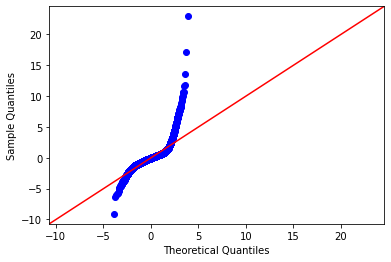

In [71]:
all_model.fit(X_train, y_train)
viz.normality_graph(all_model, X_train, y_train)

This plot indicates that our data is not very normal.

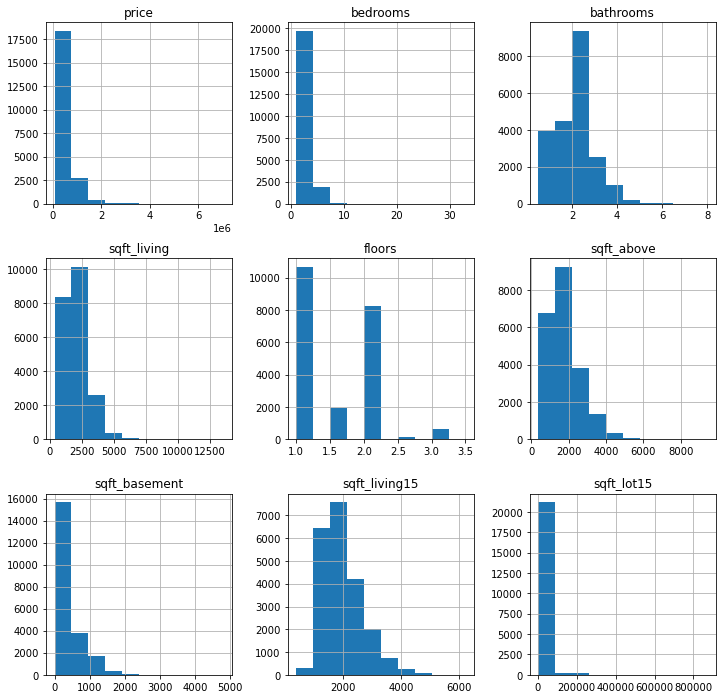

In [72]:
nonbool_columns = ['price','bedrooms','bathrooms','sqft_living','floors','sqft_above','sqft_basement', 'sqft_living15', 'sqft_lot15']
clean[nonbool_columns].hist(figsize  = [12, 12]); 

We can also see that the non-boolean columns are all skewed with lots of data cluttered around zero. We can also see that the number in the scale are also very different, with some being in the single digits and others in the thousands. We will try to deal with both these issues by log normalizing the nonboolean data.

In [73]:
nonbool_df = clean[nonbool_columns]
bool_df = clean.drop(columns=nonbool_columns)

In [74]:
nonbool_df = nonbool_df.apply(np.log1p)

In [75]:
normalized = nonbool_df.join(bool_df)

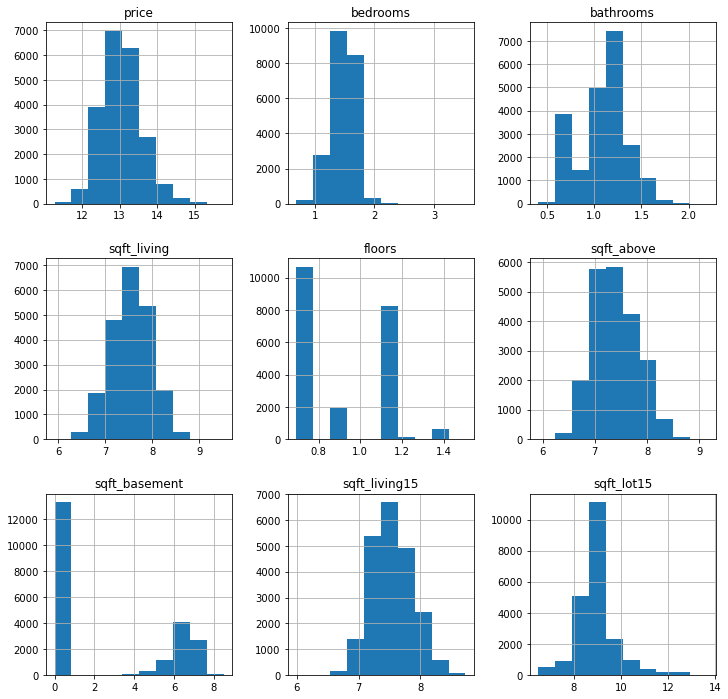

In [76]:
normalized[nonbool_columns].hist(figsize  = [12, 12]);

This is somewhat better, but sqft_basement may still be an issue. Let's construct a model using this data.

In [77]:
X_train = normalized.drop(columns='price')
y_train = normalized['price']
norm_model = LinearRegression()
norm_val = dp.cross_val(norm_model, X_train, y_train, splits=5, test_size=0.25, random_state=0)

Train score:      0.8508243904746109
Validation score: 0.8506738162610263


This is a decent improvement as it improves the validation score by about 6% to 85% from the unnormalized data. Let's check the linearity, normality and homoscedasticity of the new data to look for anamolies.

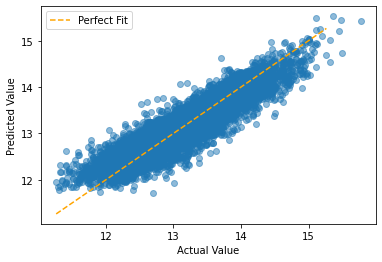

In [78]:
norm_model.fit(X_train, y_train)
viz.linearity_graph(norm_model, X_train, y_train)

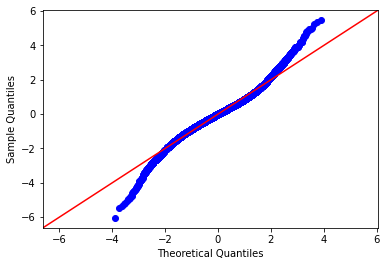

In [79]:
viz.normality_graph(norm_model, X_train, y_train)

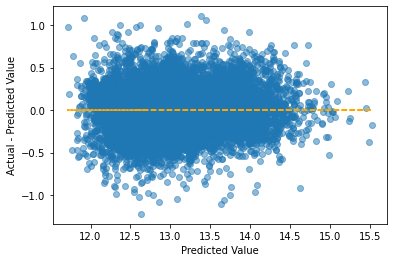

In [80]:
viz.homoscedasticity_graph(norm_model, X_train, y_train)

There is still a issue with the normality of the data. If there is an issue with the linearity or homoscedasticity, it is not apparent in the vizualizations. Let's create a model using statsmodel.api to see how an OLS model performs according to some more tests.

In [81]:
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     2015.
Date:                Wed, 29 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:02:12   Log-Likelihood:                 3853.9
No. Observations:               21583   AIC:                            -7584.
Df Residuals:                   21521   BIC:                            -7089.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.9790      0.192     57.294      0.000      10.603      11.355
bedrooms           -0.0858      0.009     -9.361      0.000      -0.104      -0.068
bathrooms           0.1095      0.010     10.533      0.000       0.089       0.130
sqft_living         0.2169      0.016     13.236      0.000       0.185       0.249
floors             -0.0710      0.011     -6.513      0.000      -0.092      -0.050
sqft_above          0.2478      0.016     15.571      0.000       0.217       0.279
sqft_basement       0.0078      0.001      7.251      0.000       0.006       0.010
sqft_living15       0.2150      0.007     29.096      0.000       0.200       0.229
sqft_lot15          0.0104      0.003      3.585      0.000       0.005       0.016
sqft_lot         5.369e-07   4.23e-08     12.706      0.000    4.54e-07     6.2e-07
waterfront          0.6455      0.017     37.127      0.000       0.611       0.680
yr_built           -0.0010   8.19e-05    -12.612      0.000      -0.001      -0.001
yr_ren_miss         0.0033      0.004      0.905      0.365      -0.004       0.010
new_ren             0.1247      0.018      7.008      0.000       0.090       0.160
old_ren             0.0793      0.009      8.937      0.000       0.062       0.097
waterfront_miss    -0.0009      0.004     -0.206      0.837      -0.010       0.008
grade_10           -0.2776      0.023    -12.258      0.000      -0.322      -0.233
grade_11           -0.1414      0.024     -5.921      0.000      -0.188      -0.095
grade_4            -0.7468      0.047    -16.038      0.000      -0.838      -0.656
grade_5            -0.7617      0.028    -27.409      0.000      -0.816      -0.707
grade_6            -0.6964      0.024    -28.570      0.000      -0.744      -0.649
grade_7            -0.6156      0.023    -26.468      0.000      -0.661      -0.570
grade_8            -0.5188      0.023    -22.862      0.000      -0.563      -0.474
grade_9            -0.3837      0.022    -17.091      0.000      -0.428      -0.340
cond_Average        0.2352      0.038      6.179      0.000       0.161       0.310
cond_Fair           0.1184      0.041      2.894      0.004       0.038       0.199
cond_Good           0.2826      0.038      7.422      0.000       0.208       0.357
cond_Very Good      0.3467      0.038      9.050      0.000       0.272       0.422
sqft_base_miss      0.0231      0.010      2.315      0.021       0.004       0.043
Auburn             -1.2233      0.030    -40.345      0.000      -1.283      -1.164
Ballard            -0.4059      0.030    -13.400      0.000      -0.465      -0.346
Bellevue           -0.4932      0.030    -16.502      0.000      -0.552      -0.435
Black Diamond      -0.9880      0.036    -27.506      0.000      -1.058      -0.918
Bothell            -0.8092      0.033    -24.601      0.000

The varibles: yr_ren_miss, waterfront_miss, and sqft_base_miss all have p-values over 0.05, this likely means that there is no significant features in common in the missing data that isn't in the other data. The condition score over 30 also indicates there is very strong multicollinearity in the model. This is probably caused by all the dummy variables. Let's run the model again without including the missing columns first and see what happens

In [82]:
drop_missing = normalized.drop(columns=['yr_ren_miss', 'waterfront_miss', 'sqft_base_miss'])

In [83]:
d_cond_model = LinearRegression()
X_train = drop_missing.drop(columns=['price'])
y_train = drop_missing['price']
d_missing_model = LinearRegression()
d_missing_val = dp.cross_val(norm_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)

Train score:      0.8514375483558094
Validation score: 0.8485849186821236


In [84]:
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     2119.
Date:                Wed, 29 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:02:42   Log-Likelihood:                 3850.8
No. Observations:               21583   AIC:                            -7584.
Df Residuals:                   21524   BIC:                            -7113.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.9883      0.192     57.365      0.000      10.613      11.364
bedrooms          -0.0859      0.009     -9.367      0.000      -0.104      -0.068
bathrooms          0.1101      0.010     10.587      0.000       0.090       0.130
sqft_living        0.2253      0.016     14.090      0.000       0.194       0.257
floors            -0.0710      0.011     -6.520      0.000      -0.092      -0.050
sqft_above         0.2395      0.016     15.449      0.000       0.209       0.270
sqft_basement      0.0071      0.001      6.879      0.000       0.005       0.009
sqft_living15      0.2149      0.007     29.086      0.000       0.200       0.229
sqft_lot15         0.0103      0.003      3.564      0.000       0.005       0.016
sqft_lot        5.376e-07   4.23e-08     12.723      0.000    4.55e-07     6.2e-07
waterfront         0.6461      0.017     37.175      0.000       0.612       0.680
yr_built          -0.0010   8.19e-05    -12.659      0.000      -0.001      -0.001
new_ren            0.1239      0.018      6.968      0.000       0.089       0.159
old_ren            0.0787      0.009      8.908      0.000       0.061       0.096
grade_10          -0.2775      0.023    -12.253      0.000      -0.322      -0.233
grade_11          -0.1411      0.024     -5.908      0.000      -0.188      -0.094
grade_4           -0.7473      0.047    -16.047      0.000      -0.839      -0.656
grade_5           -0.7620      0.028    -27.417      0.000      -0.816      -0.708
grade_6           -0.6969      0.024    -28.591      0.000      -0.745      -0.649
grade_7           -0.6159      0.023    -26.480      0.000      -0.661      -0.570
grade_8           -0.5189      0.023    -22.866      0.000      -0.563      -0.474
grade_9           -0.3838      0.022    -17.093      0.000      -0.428      -0.340
cond_Average       0.2351      0.038      6.178      0.000       0.161       0.310
cond_Fair          0.1185      0.041      2.896      0.004       0.038       0.199
cond_Good          0.2826      0.038      7.420      0.000       0.208       0.357
cond_Very Good     0.3463      0.038      9.041      0.000       0.271       0.421
Auburn            -1.2234      0.030    -40.347      0.000      -1.283      -1.164
Ballard           -0.4058      0.030    -13.397      0.000      -0.465      -0.346
Bellevue          -0.4935      0.030    -16.510      0.000      -0.552      -0.435
Black Diamond     -0.9881      0.036    -27.507      0.000      -1.059      -0.918
Bothell           -0.8093      0.033    -24.602      0.000      -0.874      -0.745
Burlen            -0.9873      0.030    -32.410      0.000      -1.047      -0.928
Capital Hill      -0.2640      0.032     -8.357      0.000      -0.326      -0.202
Carnation         -0.9225      0.035    -26.384      0.000      -0.991      -0.854
Des Moines  

Eliminating the missing value columns didn't significatly change the performance of the model either way, so we will leave them out, since it make the model slightly simpler. However, there is still a lot of collinearity in the model, since we are using the model for purposes of prediction, this is not a big issue.

In [87]:
len(drop_missing.columns)

59

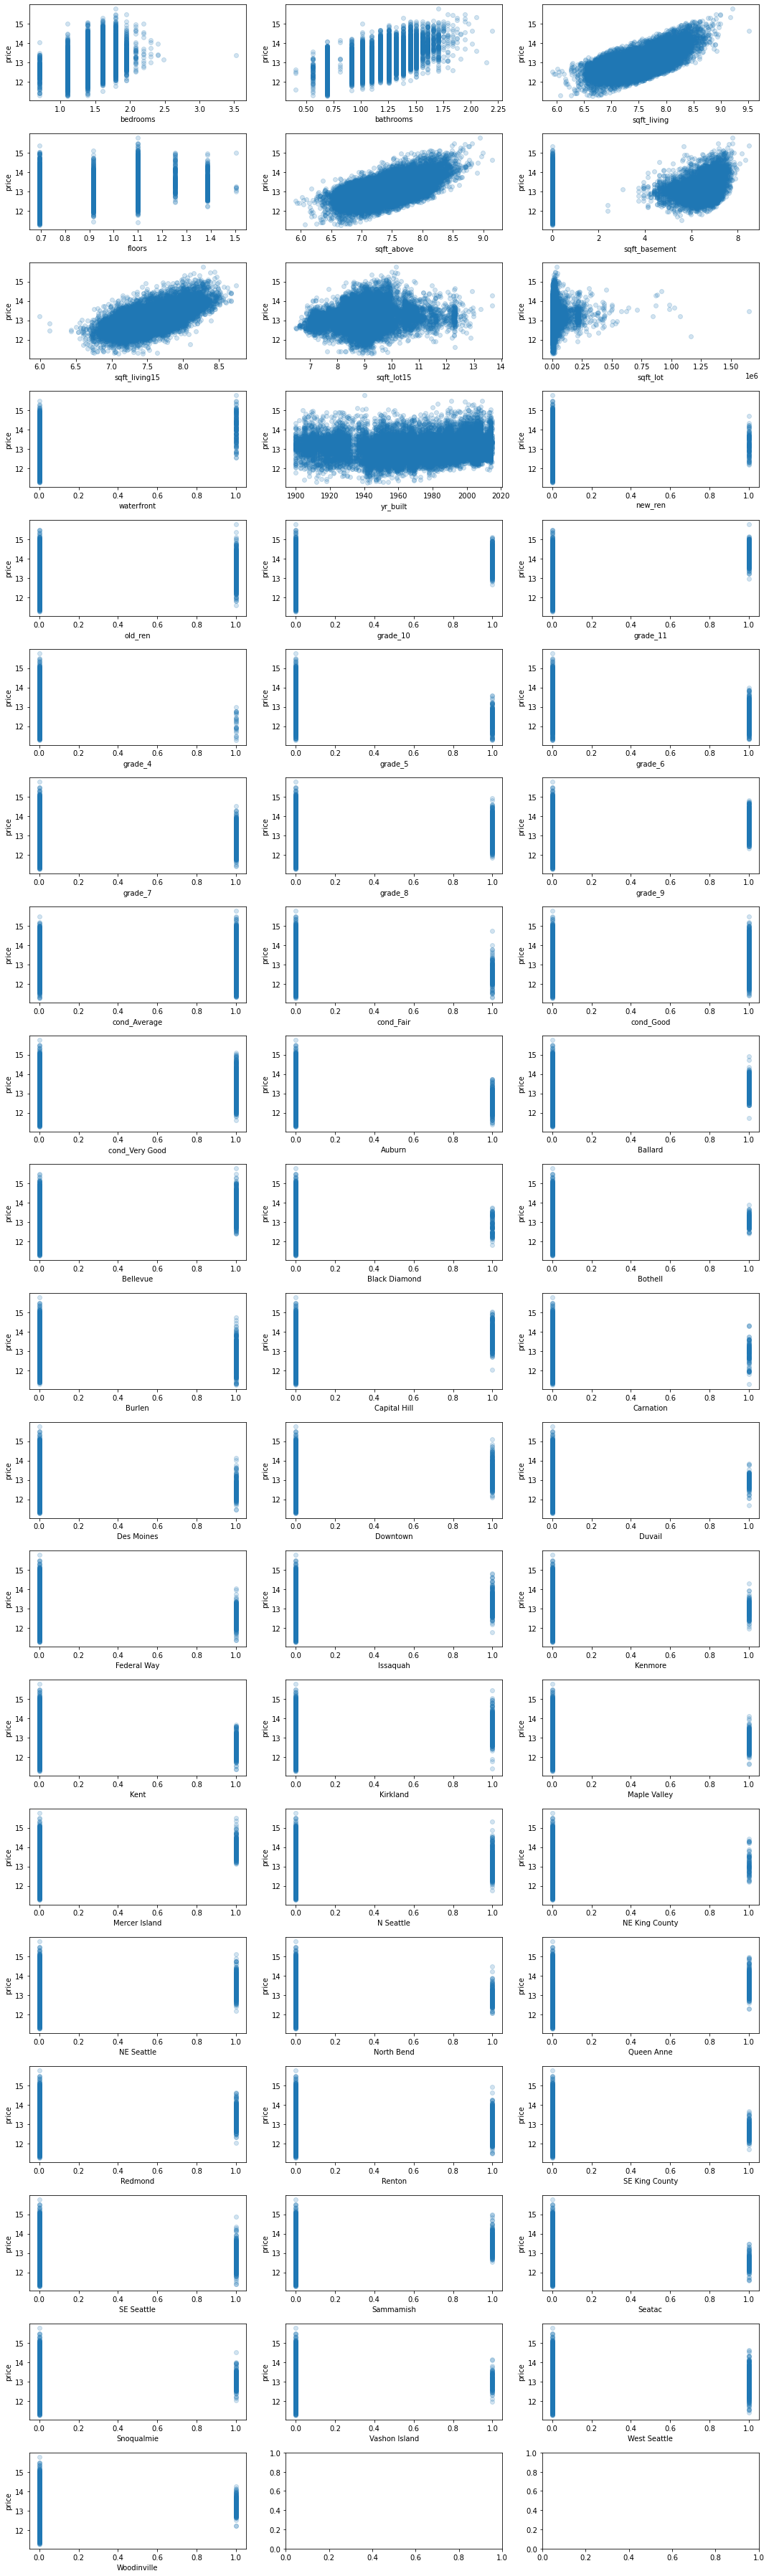

In [88]:
fig, axes = plt.subplots(ncols=3, nrows=20, figsize=(15, 50))
fig.set_tight_layout(True)

for index, col in enumerate(X_train.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("price")

There is definitely something amiss it the sqft_basement data, there seems to be a weak correlation in the non-zero data, and the missing data seems to be lower in price than the zeros. But, for now we will ignore this issue and use this model as our final model.

In [89]:
X_train = drop_missing.drop(columns=['price', 'sqft_basement'])
y_train = drop_missing['price']
d_cond_model = LinearRegression()
d_cond_val = dp.cross_val(norm_model, X_train, y_train, splits=10, test_size=0.25, random_state=0)`

Train score:      0.8511079639303223
Validation score: 0.8482707550365047


In [90]:
sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     2150.
Date:                Wed, 29 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:10:21   Log-Likelihood:                 3827.1
No. Observations:               21583   AIC:                            -7538.
Df Residuals:                   21525   BIC:                            -7075.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.0138      0.192     57.447      0.000      10.638      11.390
bedrooms          -0.0882      0.009     -9.621      0.000      -0.106      -0.070
bathrooms          0.1162      0.010     11.202      0.000       0.096       0.136
sqft_living        0.3143      0.009     33.431      0.000       0.296       0.333
floors            -0.0730      0.011     -6.697      0.000      -0.094      -0.052
sqft_above         0.1514      0.009     17.292      0.000       0.134       0.169
sqft_living15      0.2152      0.007     29.097      0.000       0.201       0.230
sqft_lot15         0.0097      0.003      3.343      0.001       0.004       0.015
sqft_lot        5.428e-07   4.23e-08     12.834      0.000     4.6e-07    6.26e-07
waterfront         0.6477      0.017     37.235      0.000       0.614       0.682
yr_built          -0.0011    8.2e-05    -12.811      0.000      -0.001      -0.001
new_ren            0.1206      0.018      6.776      0.000       0.086       0.155
old_ren            0.0787      0.009      8.895      0.000       0.061       0.096
grade_10          -0.2798      0.023    -12.342      0.000      -0.324      -0.235
grade_11          -0.1420      0.024     -5.936      0.000      -0.189      -0.095
grade_4           -0.7531      0.047    -16.158      0.000      -0.844      -0.662
grade_5           -0.7683      0.028    -27.631      0.000      -0.823      -0.714
grade_6           -0.7033      0.024    -28.840      0.000      -0.751      -0.655
grade_7           -0.6211      0.023    -26.691      0.000      -0.667      -0.576
grade_8           -0.5229      0.023    -23.024      0.000      -0.567      -0.478
grade_9           -0.3876      0.022    -17.250      0.000      -0.432      -0.344
cond_Average       0.2373      0.038      6.228      0.000       0.163       0.312
cond_Fair          0.1227      0.041      2.996      0.003       0.042       0.203
cond_Good          0.2843      0.038      7.457      0.000       0.210       0.359
cond_Very Good     0.3465      0.038      9.034      0.000       0.271       0.422
Auburn            -1.2234      0.030    -40.303      0.000      -1.283      -1.164
Ballard           -0.4032      0.030    -13.300      0.000      -0.463      -0.344
Bellevue          -0.4925      0.030    -16.461      0.000      -0.551      -0.434
Black Diamond     -0.9881      0.036    -27.476      0.000      -1.059      -0.918
Bothell           -0.8079      0.033    -24.535      0.000      -0.872      -0.743
Burlen            -0.9851      0.030    -32.306      0.000      -1.045      -0.925
Capital Hill      -0.2571      0.032     -8.133      0.000      -0.319      -0.195
Carnation         -0.9231      0.035    -26.373      0.000      -0.992      -0.854
Des Moines        -1.1355      0.032    -35.488      0.000      -1.198      -1.073
Downtown    

In [ ]:
final_model = LinearRegression()
X_train = cond_rated.drop(columns='price')
y_train = cond_rated['price']
final_model.fit(X_train, y_train)

## Interpreting the Model

So we have our final model, unfortunately since we standardized the scores and log normalize the data, the coeffients are not as directly interpretable since they are not in the units or scale of the original values.

In [ ]:
coef = pd.DataFrame(np.zeros((1, len(X_train.columns))))
coef.columns = X_train.columns
coef[X_train.columns] = final_model.coef_
coef.insert(0, 'price', final_model.intercept_)
coef

But we can make a function that will give us rescaled difference between the predictions about the median homes with different features to get a feel for the data. For example our model predicts that the median 2 bathroom home is valued $51,318 more than the median 1 bathroom home.

In [ ]:
round(dp.predict_difference(final_model, X_train, 'bathrooms', 1, 2, scaler_cond, nonbool_columns), ndigits=2)

We can also construct some visualizations to see these predictions and the data they are based on more clearly for all the variables.

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
fig.set_tight_layout(True)
cols = ['bedrooms','bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above']

for index, col in enumerate(cols):
    predict_df = dp.predict_median_effect(X_train, col, nonbool_columns, scaler_cond, final_model)
    ax = axes[index//3][index%3]
    ax.scatter(predict_df[col], predict_df['price']/1000, alpha = 0.4)
    clean_med = clean.groupby(col).median().reset_index()
    ax.scatter(clean_med[col], clean_med['price']/1000, c='orange', alpha = 0.4)
    ax.set_xlabel(col)
    ax.set_ylabel("price")
    ax.legend(labels=['Prediction', 'Data'])

We can see the error is quite large in some areas, to get a better grip on what that means in practice, let's calculate the unstandardized mean squared error of the model.

In [ ]:
X = cond_rated.drop(columns='price')
y = cond_rated['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
dp.unstandard_mean_sq_error(final_model, X_train, y_train, X_test, y_test, scaler=scaler_cond)

This is obviously a very large real world error, but we can see from the visualizations that much of this error is coming from the larger more expensive homes, and that the model is being too conservative about their prices. It's predictions are much more accurate for the more median home.

To end we created a function that can be used to get predictions from the model for input values. For example, we can use it to predict that a 3 bedroom home with 2 bathrooms with 1 floor of 1200 sqft and a 500 sqft basement, that is in good condition and has an average grade score, and was renovated, but not recently, would have a predicted price of $544,664

In [ ]:
dp.give_prediction(final_model, X_train.columns, scaler_cond, nonbool_columns)